# Cats and Dogs
by uramoon@kw.ac.kr<br><br>
고양이와 개를 분류하는 간단한(?) 모델을 만들어봅시다!<br>
런타임 유형은 가급적 GPU로 설정하세요. <br><br>

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/15<br>
**Last modified:** 2020/05/12<br>
**Description:** Complete guide to transfer learning & fine-tuning in Keras.<br>
(<a href="https://raw.githubusercontent.com/ronreiter/interactive-tutorials/master/LICENSE">Apache 2.0 License</a>)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

## 데이터 가져오기
원래 25,000장의 그림이 있는데 15,000장만 가져와서 그 중 10,000장은 훈련, 2500장은 검증, 2500장은 테스트에 사용하겠습니다.<br>
(오염된 이미지들이 있어서 다 받아오진 못하고 수 백장의 사진이 걸러집니다.)

In [2]:
# 텐서플로우에서 제공하는 데이터셋 가져오기
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

# 훈련 데이터셋, 검증 데이터셋, 테스트 데이터셋
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs", # 개와 고양이 데이터셋
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete5IXUZJ/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


## 데이터셋 살펴보기<br>


In [ ]:
train_ds

<MapDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

(262, 350, 3)


Text(0.5, 1.0, 'DOG')

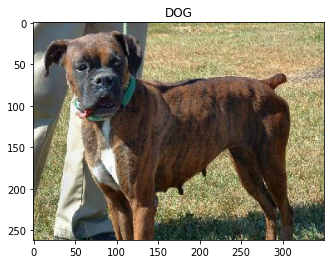

In [3]:
import matplotlib.pyplot as plt

# 훈련 데이터셋에서 하나의 데이터만 가져오기
# take는 튜플(순서쌍)을 반환하므로 ,로 첫 번째 원소만 가져옵니다.
data, = train_ds.take(1)

# 데이터 안에는 이미지(그림)와 레이블(정답)이 기재되어 있습니다.
image = data[0] #TODO: data의 첫 번째 원소
label = data[1] #TODO: data의 두 번째 원소
# print("data shape : ", data)

# TODO: 이미지 모양 (shape) 출력해보기
print(image.shape)

# TODO: 코드 한 줄로 image 그려보기 
plt.imshow(image)

# TODO: 그림 위에 title 달기 / 0은 고양이, 1은 개
if int(label) == 0:
  name = 'CAT'
else:
  name = 'DOG'
plt.title(name)

## TODO1: 훈련 데이터 그려보기
훈련 데이터의 첫 9장을 그려봅시다.

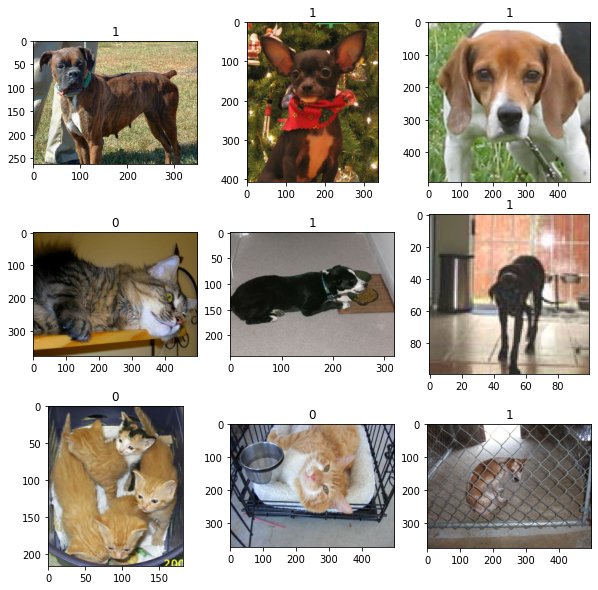

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)): # TODO: take 함수로 9장 가져오세요.
    ax = plt.subplot(3, 3, i + 1)
    # TODO: image를 그리세요.
    plt.imshow(image)
    # TODO: 0인지 1인지 타이틀로 표시하세요.
    plt.title(int(label))
plt.show()

## TODO2: 데이터셋 전처리하기
나중에 우리는 150 x 150 크기의 그림을 입력으로 받는 Xception 모델을 사용할 것이기 때문에<br> 그림 크기를 150 x 150으로 변환하고 Xception의 전처리 기법을 사용하겠습니다.

In [4]:
size = (150, 150)

# train_ds의 모든 원소에 대해 람다라는 이름 없는 함수를 적용합니다.
# 각 원소는 이미지 (x)와 레이블 (y)을 순서대로 갖고 있는데, x에는 resize 함수를 적용하여 반환하고, y는 그대로 반환합니다.
# 원래 이미지는 [0, 255]에 해당하는 int였는데, resize 함수가 [0, 255] float으로 타입을 바꿉니다.
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y)) #TODO
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y)) #TODO

In [5]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

# 람다 함수를 사용해 각 데이터셋의 x (이미지)에만 preprocess_input을 적용해보세요.
# [0, 255] float이 [-1, 1] float으로 바뀝니다.
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y)) #TODO
validation_ds = validation_ds.map(lambda x, y: (preprocess_input(x), y)) #TODO
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y)) #TODO

In [6]:
# 빠른 속도를 위해 데이터셋을 32장씩 묶어 준비합니다.
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

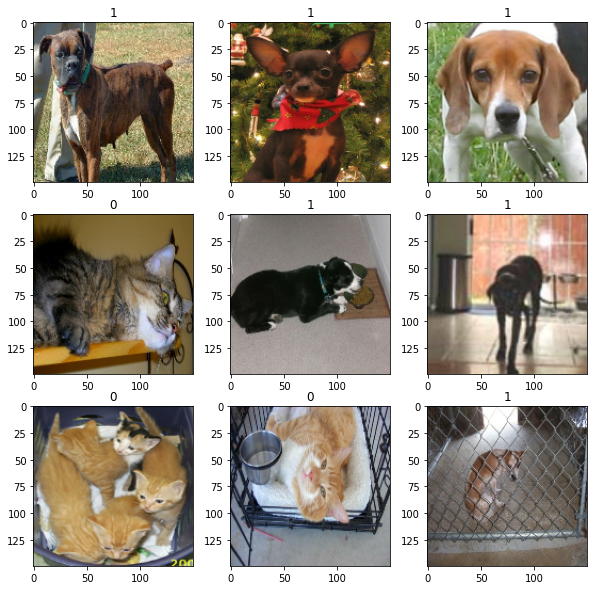

In [7]:
# 훈련 데이터 첫 9장을 그려보세요.

plt.figure(figsize=(10, 10))
batch, = train_ds.take(1) # 이제부터 1의 의미는 한 묶음 (32장) 가져오기

images, labels = batch[0], batch[1]  #TODO: 한 줄로 할당해보세요. 두 줄로 하셔도 됩니다.

# TODO1의 리사이징 버전이 그려져야 합니다.

for i, image in enumerate(images[:9]): #TODO: images 첫 9장 슬라이싱하세요.
  ax = plt.subplot(3, 3, i + 1)
  # matplotlib은 [0, 255] int나 [0, 1] float을 제대로 그리기 때문에 
  # 우리의 입력인 [-1, 1] float은 이상하게 그려집니다.
  # 그냥 그려봐도 되고 image에 1을 먼저 더한 후 2로 나누어서 [0, 1] float으로 그려도 됩니다. 
  # (NumPy에서는 다차원 배열의 각 원소에도 손쉽게 덧셈, 나눗셈이 가능합니다.)
  # TODO: image 그리기
  plt.imshow((image+1)/2)

  # TODO: 0/1 title 설정하기
  plt.title(int(labels[i]))  
  
plt.show()

## TODO3: 데이터 늘리기<br>
이미지와 레이블을 배열로 관리할 때에는 ImageDataGenerator 사용이 편리하지만 <br>
DataSet 사용시에는 딥러닝 모델에 데이터를 변환하는 층을 넣어주는 것이 편합니다.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

# 좌우로 뒤집는 층과 10% * 360도 시계, 반시계로 회전하는 층을 만들어보세요.
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'), layers.RandomRotation(0.1),] #TODO: 각 괄호 안에 값을 넣으셔야 합니다.
)

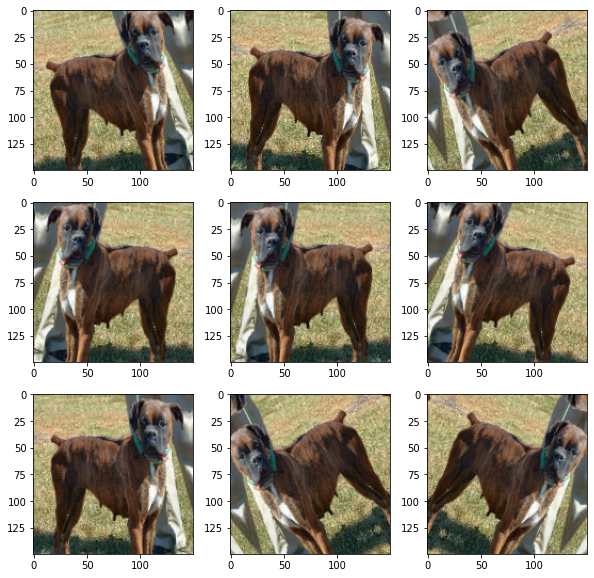

In [9]:
# TODO: 전처리된 훈련 데이터셋(train_ds)에서 첫 번째 그림을 가져오세요.
image = images[0]  # images에서 가져오시면 쉽습니다.

# TODO: 훈련 데이터의 첫 번째 그림을 데이터 증강층으로 변형하여 9장 그려보세요.
# 의도한 훈련 데이터가 생성되는지 확인하고 그렇지 않다면 데이터 증강층을 다시 만드세요.
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  # 딥러닝 층으로 들어갈 때에는 (그림 인덱스, 세로, 가로, 채널)로 들어가야 합니다.
  # 현재 image는 (세로, 가로, 채널)입니다. 차원 늘리기 필요.

  image = np.reshape(image, (1, 150, 150, 3))

  pic = data_augmentation(image, training=True) # TODO: image의 차원을 늘려서 입력하세요. 차원 늘리는 함수 혹은 reshape도 가능
  
  # Q: training 옵션은 현재 훈련 중인지 아닌지를 알려주는데 증강층은 훈련할 때에만 동작합니다.
  # 즉 실전에 투입되어 모르는 그림을 인식할 때에는 동작하지 않습니다. 왜 그럴까요? (중요)
  # A:

  # 의미 없이 늘린 차원 다시 줄이기 
  np.reshape(image, (150, 150, 3) )

  pic = pic[0] #TODO: 첫 번째 그림 선택하면 쉽습니다.
  # TODO: pic을 그려보세요. 
  plt.imshow((pic+1)/2) 

plt.show()  

## TODO4: 모델 정의하기<br>
클래스가 0 (고양이)와 1 (개) 밖에 없으므로 loss는 binary_crossentropy를 사용합니다.<br>
입력은 (150, 150, 3), 마지막 출력층은 노드가 하나입니다. (0이면 고양이, 1이면 개)<br>
출력은 하나의 노드에서 0 또는 1이므로 출력층의 활성화 함수는 softmax 대신 sigmoid 등을 사용해야 합니다.<br>
softmax는 여러 개 중에서 무엇을 선택할까인데 여기에 사용하면 무조건 하나의 출력 노드를 1로 만듭니다.<br>
sigmoid (S자형 곡선)의 경우에는 0과 1사이의 값을 출력합니다. (Cats vs. Dogs)<br>
그 외에는 자유롭게 만드세요. (Conv2D 층은 꼭 사용하시기 바랍니다.)

In [12]:
from keras import models
from keras import layers

model = models.Sequential()

# 입력층
model.add(layers.Input(shape=(150, 150, 3)))

# 데이터 증강층
model.add(layers.RandomFlip('horizontal')) #TODO: 위에서 만든 층을 넣으세요.
model.add(layers.RandomRotation(0.1))

# 자유롭게 설정

model.add(layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=256, kernel_size = (3,3), activation="relu"))    
model.add(layers.MaxPooling2D(pool_size=(2,2)))


# 층 추가


# 출력층
# TODO: 노드 수와 활성화 함수 기재
model.add(layers.Flatten()) 

# 추가 안하는게 정답률 더 높음
# keras.layers.Dense(300, kernel_initializer="he_normal"),
# keras.layers.PReLU(),
# keras.layers.Dense(100, kernel_initializer="he_normal"),
# keras.layers.PReLU(),

model.add(layers.Dense(1,activation="sigmoid"))
    
# 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"]) # loss에 softmax 사용 금지

In [ ]:
# 훈련해야 하는 파라미터가 몇 개인지 확인해보세요.
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_4 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 150, 150, 3)      0         
 tation)                                                         
                                                                 
 conv2d_15 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 conv2d_16 (Conv2D)          (None, 146, 146, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 71, 71, 128)      

## TODO5: 모델 훈련

In [13]:
# validation_ds도 제공하여 테스트 데이터에 대한 성능도 가늠해보세요.
# 여기에서 너무 많은 시간을 사용하지 마세요. (정확도 70% 이상, 30분 이내 완료 추천)

epochs = 3
batch_size = 64

model.fit(train_ds, batch_size=batch_size, epochs=epochs,
          validation_data=(validation_ds))

Epoch 1/3
291/291 [==============================] - 2867s 10s/step - loss: 0.6767 - accuracy: 0.5632 - val_loss: 0.6490 - val_accuracy: 0.6023
Epoch 2/3
291/291 [==============================] - 2858s 10s/step - loss: 0.5933 - accuracy: 0.6710 - val_loss: 0.5396 - val_accuracy: 0.7309
Epoch 3/3
291/291 [==============================] - 2861s 10s/step - loss: 0.5279 - accuracy: 0.7340 - val_loss: 0.4964 - val_accuracy: 0.7687


## TODO6: 테스트 데이터로 평가하기

In [14]:
# 평가해보세요.
model.evaluate(test_ds)

73/73 [==============================] - 180s 2s/step - loss: 0.4884 - accuracy: 0.7635


[0.4883682131767273, 0.7635425329208374]